In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Simplicit Uniswap V2

## Concept

### Constant product formula
$$x \cdot y = k$$
where:
$$\\ \text{x: stable asset} \\ \text{y: volatilie asset } \\ \text{k: constant }
$$

### exchange rate
Determine by $\frac{x}{y}$ while preserving the product  $\ x\cdot y$

1. When sell token x, we will receive token y:

$$
x \cdot y = (x + \Delta x) \cdot (y - \Delta y) \\
$$
where:

$(x+ \Delta x)$:  new amount of token x

$(y - \Delta y)$: new amounut of token y


2. When trading $\Delta y$ for $\Delta x$, the update formulas are:
$$
x' = x + \Delta x = (1 - \alpha) \cdot x = \frac{1}{x(1 - \beta)} \\
y' = y - \Delta y = \frac{y}{1+\alpha} = y(1-\beta)
$$

where: $\alpha = \frac{\Delta x}{x}, \beta = \frac{\Delta y}{y}$ :

$$
\Delta x = x(\frac{\beta }{ 1-\beta})
\\
\Delta y = y(\frac{\alpha}{ 1 + \alpha})
$$

### Transaction fees paids to liquidity providers
fees rate $p = 0.003$, Trading formula with fees rate:
$$
xp' = x + \Delta x = x(1 + \alpha) = (1 + \beta\frac{1}{y-1}) \cdot \frac{x}{1-\beta}
\\
yp' = y - \Delta y = \frac{y}{1 + \alpha y} = y(1-\beta)
$$

when fees are present $p > 0, xp' \cdot yp' > x \cdot y$

In [7]:
class UniswapV2:
  """ Simplicit Uniswap V2 """



  def __init__(self,price_x, price_y,fee_rate=0.003):
    """
    x: stable asset
    y: volatile asset
    k: constants
    """
    self.x = 0
    self.y = 0
    self.k = 0
    self.total_fees_in_x = 0
    self.total_fees_in_y = 0

    # base asset price
    self.price_x = price_x

    # quote assets price  ( price in asset x unit)
    self.price_y = price_y
    self.fee_rate = fee_rate



  @staticmethod
  def cal_alpha(delta_x, x):
    return delta_x/x

  @staticmethod
  def cal_beta(delta_y,y):
    return delta_y/y

  def _cal_delta_x(self, delta_y):
    beta = self.cal_beta(delta_y, self.y)
    delta_x =  self.x * (beta/(1-beta))
    return delta_x

  def _cal_delta_y(self, delta_x):
    alpha = self.cal_alpha(delta_x, self.x)
    delta_y = self.y * (alpha/(1+alpha))
    return delta_y


  def swap_x_to_y(self, delta_x):
    y_out = self._cal_delta_y(delta_x)
    self.y -= y_out
    self.x += delta_x
    fees = self.fee_rate * y_out
    y_out = y_out - fees

    self.total_fees_in_y += fees
    return y_out

  def swap_y_to_x(self, delta_y):
    x_out = self._cal_delta_x(delta_y)

    fees = self.fee_rate * x_out
    x_out = x_out - fees
    self.x -= x_out
    self.y += delta_y
    self.total_fees_in_x += fees

    return x_out

  def _update_price_y(self, market_price):
    self.price_y = market_price

  def rebalance_pool(self, market_price):
    self._update_price_y(market_price)
    y_new = (self.k / self.price_y) ** 0.5
    x_new = self.price_y * y_new

    # Update the reserves
    self.x = x_new
    self.y = y_new
    if self.x is not None and self.y is not None:
      self.k = self.x * self.y
    else:
      self.k = None

  def calculate_tvl(self):
    value_stable = self.x
    value_volatile = self.y * self.price_y

    tvl = value_stable + value_volatile
    return tvl

  def add_liquidity(self, delta_x=None, delta_y=None):
    if delta_x is not None and delta_y is None:
      delta_y = delta_x / self.price_y
      self.x += delta_x
      self.y += delta_y

    elif delta_y is not None and delta_x is None:
      delta_x = delta_y * self.price_y
      self.x += delta_x
      self.y += delta_y

    self.k = self.x * self.y

  def get_total_fees_in_x(self):
      return self.total_fees_in_x + (self.total_fees_in_y * self.price_y)

  def get_total_fees_in_y(self):
      return self.total_fees_in_y + (self.total_fees_in_x/self.price_y)


## Scenario 1: ETH price goes up

In [8]:
tvl_history = []
x_balance_history = []
y_balance_history = []
price_y_history = []

# Create pool ETH/USD
ethusd_pool = UniswapV2(price_x=1, price_y=2000)

# Add Liquidity
ethusd_pool.add_liquidity(delta_y=2000)

for i in range(100):
  ethusd_pool.rebalance_pool(market_price=ethusd_pool.price_y * 1.01)
  tvl_history.append(ethusd_pool.calculate_tvl())
  x_balance_history.append(ethusd_pool.x)
  y_balance_history.append(ethusd_pool.y)
  price_y_history.append(ethusd_pool.price_y)


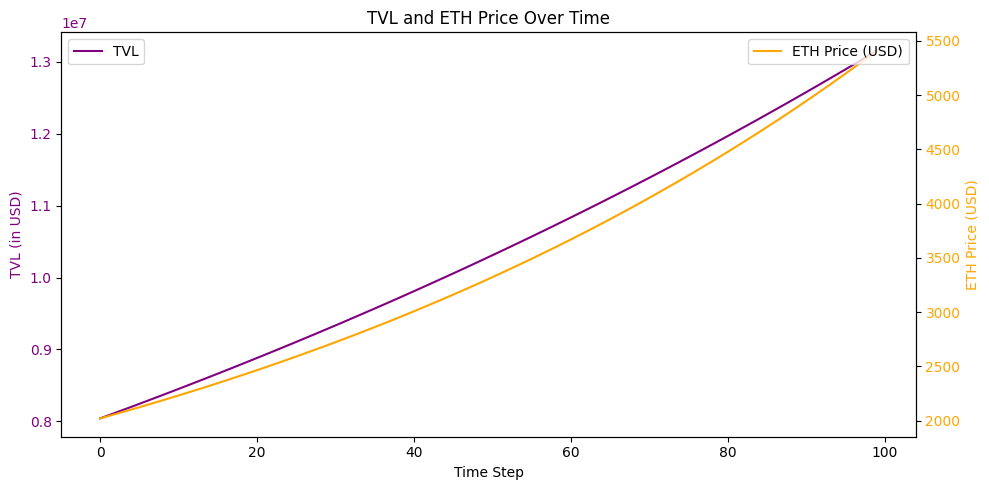

In [9]:
#@title TVL Over Time


fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(tvl_history, label='TVL', color='purple')
ax1.set_title("TVL and ETH Price Over Time")
ax1.set_xlabel("Time Step")
ax1.set_ylabel("TVL (in USD)", color='purple')
ax1.tick_params(axis='y', labelcolor='purple')

ax2 = ax1.twinx()
ax2.plot(price_y_history, label='ETH Price (USD)', color='orange')
ax2.set_ylabel("ETH Price (USD)", color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


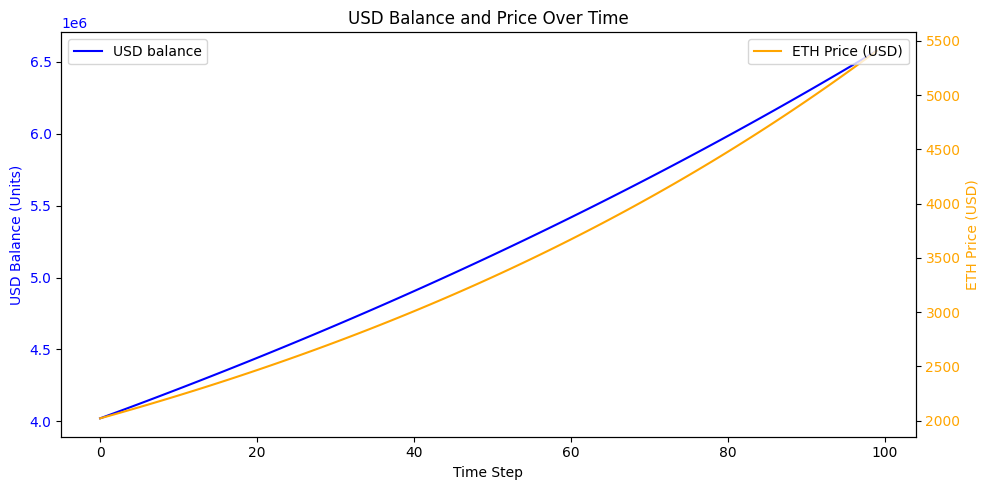

In [10]:
#@title USD Balance Over Time

fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(x_balance_history, label='USD balance', color='blue')
ax1.set_title("USD Balance and Price Over Time")
ax1.set_xlabel("Time Step")
ax1.set_ylabel("USD Balance (Units)", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(price_y_history, label='ETH Price (USD)', color='orange')
ax2.set_ylabel("ETH Price (USD)", color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


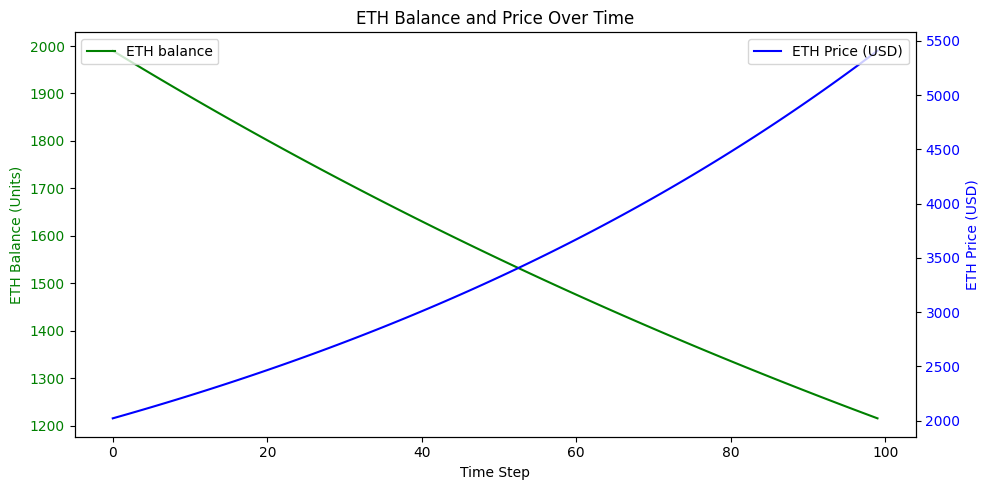

In [11]:
#@title ETH Balance Over Time
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(y_balance_history, label='ETH balance', color='green')
ax1.set_title("ETH Balance and Price Over Time")
ax1.set_xlabel("Time Step")
ax1.set_ylabel("ETH Balance (Units)", color='green')
ax1.tick_params(axis='y', labelcolor='green')

ax2 = ax1.twinx()
ax2.plot(price_y_history, label='ETH Price (USD)', color='blue')
ax2.set_ylabel("ETH Price (USD)", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

## Scenario 2: ETH goes down

In [12]:
tvl_history = []
x_balance_history = []
y_balance_history = []
price_y_history = []

# Create pool ETH/USD
ethusd_pool = UniswapV2(price_x=1, price_y=2000)

# Add Liquidity
ethusd_pool.add_liquidity(delta_y=2000)

for i in range(100):
  ethusd_pool.rebalance_pool(market_price=ethusd_pool.price_y * 0.95)
  tvl_history.append(ethusd_pool.calculate_tvl())
  x_balance_history.append(ethusd_pool.x)
  y_balance_history.append(ethusd_pool.y)
  price_y_history.append(ethusd_pool.price_y)

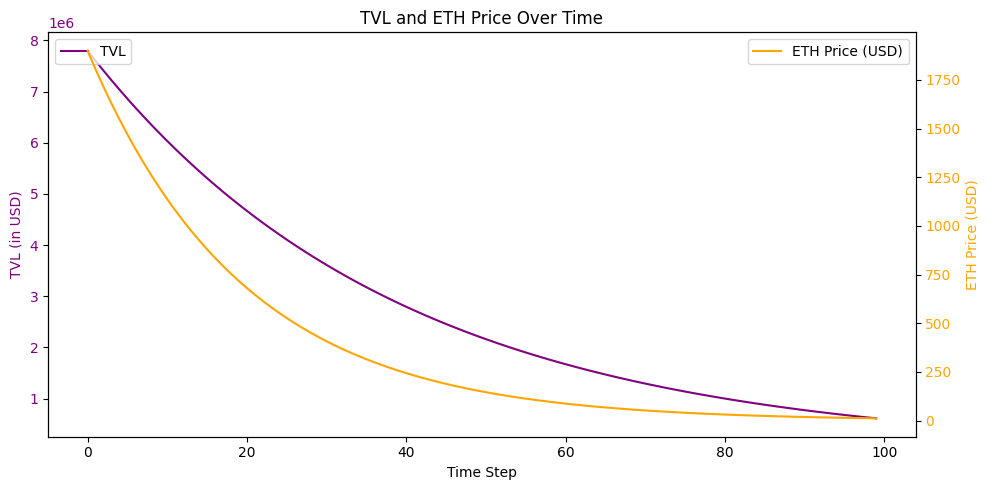

In [13]:
#@title TVL Over Time


fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(tvl_history, label='TVL', color='purple')
ax1.set_title("TVL and ETH Price Over Time")
ax1.set_xlabel("Time Step")
ax1.set_ylabel("TVL (in USD)", color='purple')
ax1.tick_params(axis='y', labelcolor='purple')

ax2 = ax1.twinx()
ax2.plot(price_y_history, label='ETH Price (USD)', color='orange')
ax2.set_ylabel("ETH Price (USD)", color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


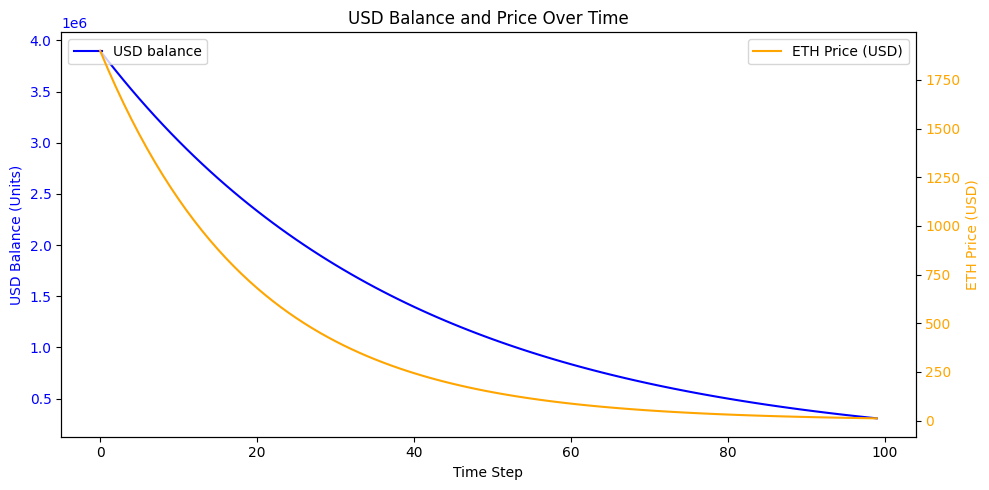

In [14]:
#@title USD Balance Over Time

fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(x_balance_history, label='USD balance', color='blue')
ax1.set_title("USD Balance and Price Over Time")
ax1.set_xlabel("Time Step")
ax1.set_ylabel("USD Balance (Units)", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(price_y_history, label='ETH Price (USD)', color='orange')
ax2.set_ylabel("ETH Price (USD)", color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


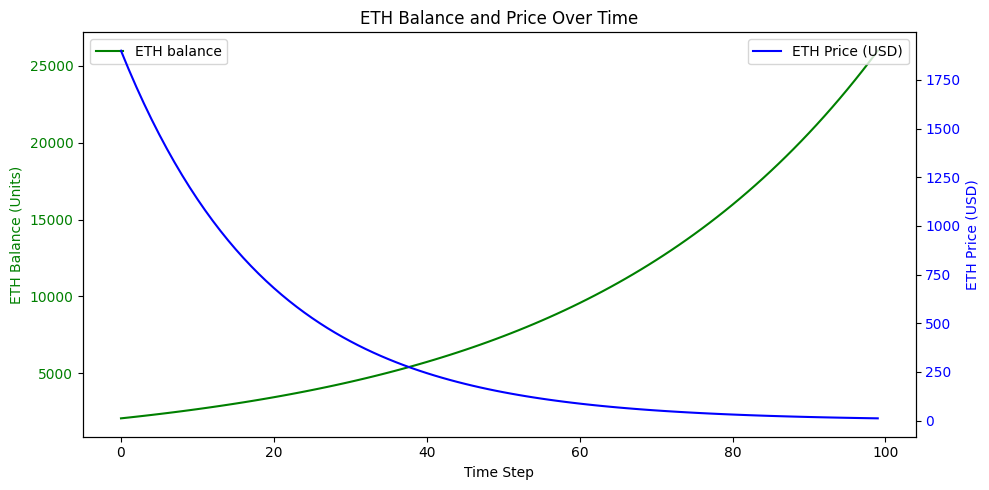

In [15]:
#@title ETH Balance Over Time
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(y_balance_history, label='ETH balance', color='green')
ax1.set_title("ETH Balance and Price Over Time")
ax1.set_xlabel("Time Step")
ax1.set_ylabel("ETH Balance (Units)", color='green')
ax1.tick_params(axis='y', labelcolor='green')

ax2 = ax1.twinx()
ax2.plot(price_y_history, label='ETH Price (USD)', color='blue')
ax2.set_ylabel("ETH Price (USD)", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

## Scenario3: High Volatility

In [16]:

tvl_history = []
x_balance_history = []
y_balance_history = []
price_y_history = []

# Create pool ETH/USD
ethusd_pool = UniswapV2(price_x=1, price_y=2000)

# Add Liquidity
ethusd_pool.add_liquidity(delta_y=2000)

for i in range(100):
  fluctuation = np.random.uniform(0.75, 1.2)
  ethusd_pool.rebalance_pool(market_price=ethusd_pool.price_y * fluctuation)
  tvl_history.append(ethusd_pool.calculate_tvl())
  x_balance_history.append(ethusd_pool.x)
  y_balance_history.append(ethusd_pool.y)
  price_y_history.append(ethusd_pool.price_y)

for i in range(100):
  fluctuation = np.random.uniform(0.95, 1.1)
  ethusd_pool.rebalance_pool(market_price=ethusd_pool.price_y * fluctuation)
  tvl_history.append(ethusd_pool.calculate_tvl())
  x_balance_history.append(ethusd_pool.x)
  y_balance_history.append(ethusd_pool.y)
  price_y_history.append(ethusd_pool.price_y)

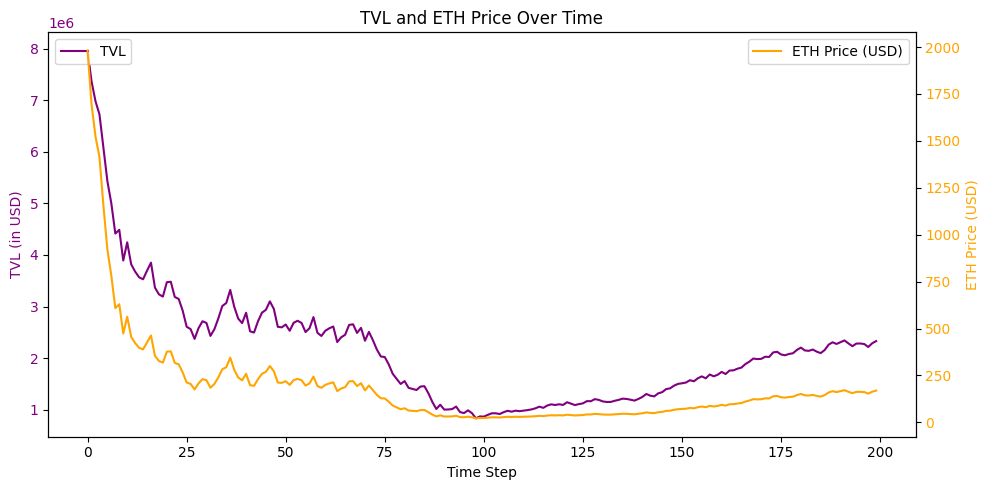

In [17]:
#@title TVL Over Time


fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(tvl_history, label='TVL', color='purple')
ax1.set_title("TVL and ETH Price Over Time")
ax1.set_xlabel("Time Step")
ax1.set_ylabel("TVL (in USD)", color='purple')
ax1.tick_params(axis='y', labelcolor='purple')

ax2 = ax1.twinx()
ax2.plot(price_y_history, label='ETH Price (USD)', color='orange')
ax2.set_ylabel("ETH Price (USD)", color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


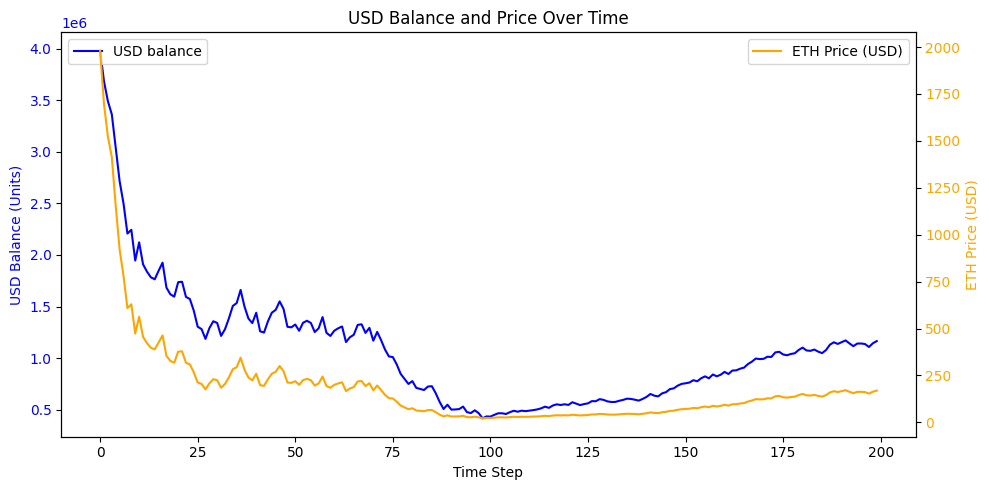

In [18]:
#@title USD Balance Over Time

fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(x_balance_history, label='USD balance', color='blue')
ax1.set_title("USD Balance and Price Over Time")
ax1.set_xlabel("Time Step")
ax1.set_ylabel("USD Balance (Units)", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(price_y_history, label='ETH Price (USD)', color='orange')
ax2.set_ylabel("ETH Price (USD)", color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


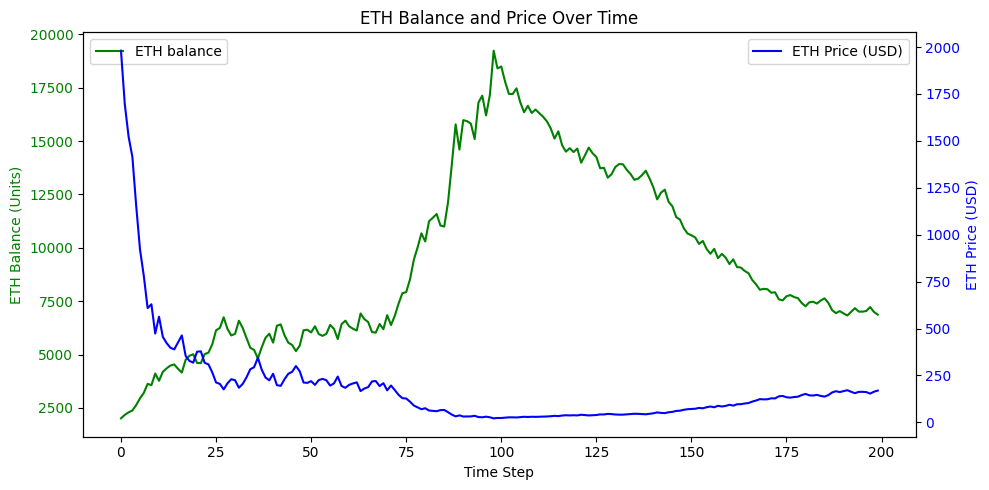

In [19]:
#@title ETH Balance Over Time
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(y_balance_history, label='ETH balance', color='green')
ax1.set_title("ETH Balance and Price Over Time")
ax1.set_xlabel("Time Step")
ax1.set_ylabel("ETH Balance (Units)", color='green')
ax1.tick_params(axis='y', labelcolor='green')

ax2 = ax1.twinx()
ax2.plot(price_y_history, label='ETH Price (USD)', color='blue')
ax2.set_ylabel("ETH Price (USD)", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

## Scenario 4: High Volatility with Swaps

In [20]:

tvl_history = []
x_balance_history = []
y_balance_history = []
price_y_history = []
fees_history = []
swap_count_history = []

# Create pool ETH/USD
ethusd_pool = UniswapV2(price_x=1, price_y=2000)

# Add Liquidity
ethusd_pool.add_liquidity(delta_y=2000)

for i in range(100):
  fluctuation = np.random.uniform(0.75, 1.2)
  ethusd_pool.rebalance_pool(market_price=ethusd_pool.price_y * fluctuation)

  daily_swaps = 0
  daily_swaps_fee = 0

  for _ in range(np.random.randint(100,1001)):
    if np.random.rand() < 0.5:
      delta_x = np.random.uniform(0.01,0.05) * ethusd_pool.x
      fee = (ethusd_pool.swap_x_to_y(delta_x))* 0.003
      swap_fee = fee * ethusd_pool.x # convert to usd
      daily_swaps_fee += swap_fee

    else:
      delta_y = np.random.uniform(0.01,0.05) * ethusd_pool.y
      swap_fee = (ethusd_pool.swap_y_to_x(delta_y)) * 0.003
      daily_swaps_fee += swap_fee

    daily_swaps += 1

  tvl_history.append(ethusd_pool.calculate_tvl())
  x_balance_history.append(ethusd_pool.x)
  y_balance_history.append(ethusd_pool.y)
  price_y_history.append(ethusd_pool.price_y)
  fees_history.append(daily_swaps_fee)
  swap_count_history.append(daily_swaps)


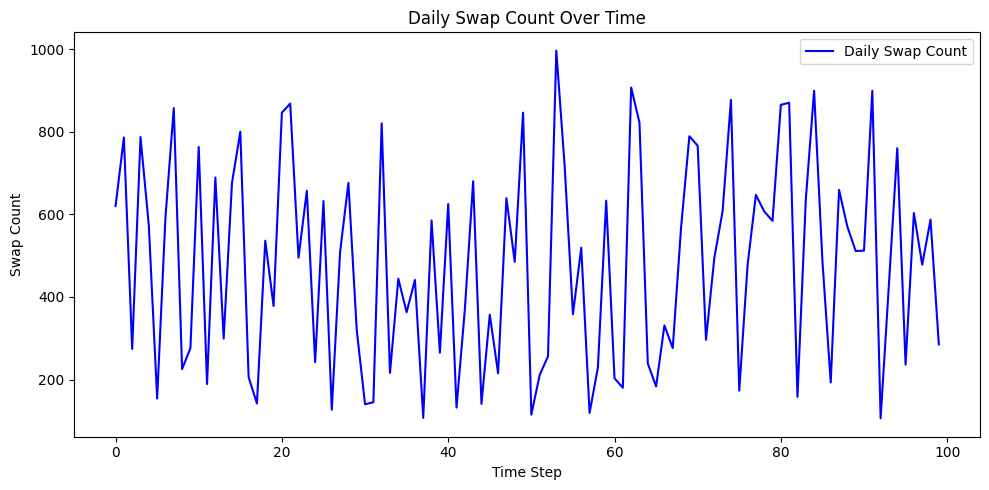

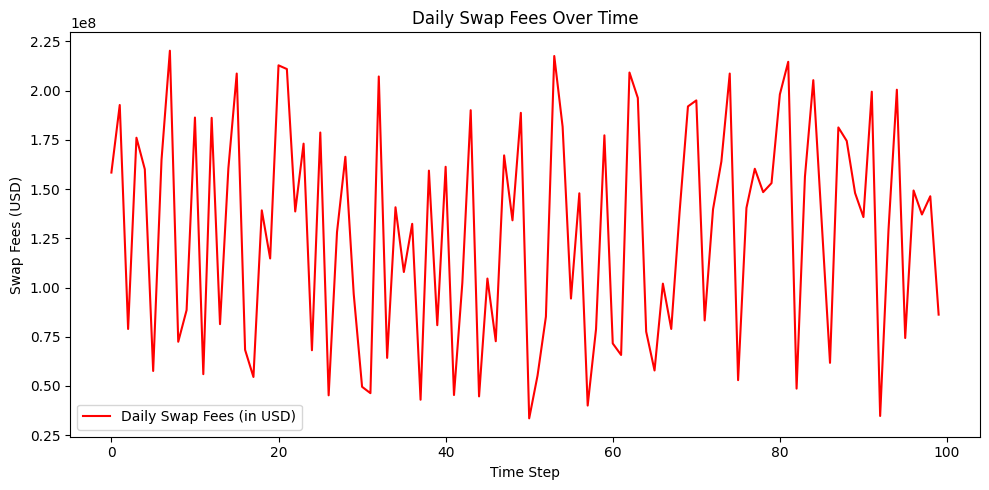

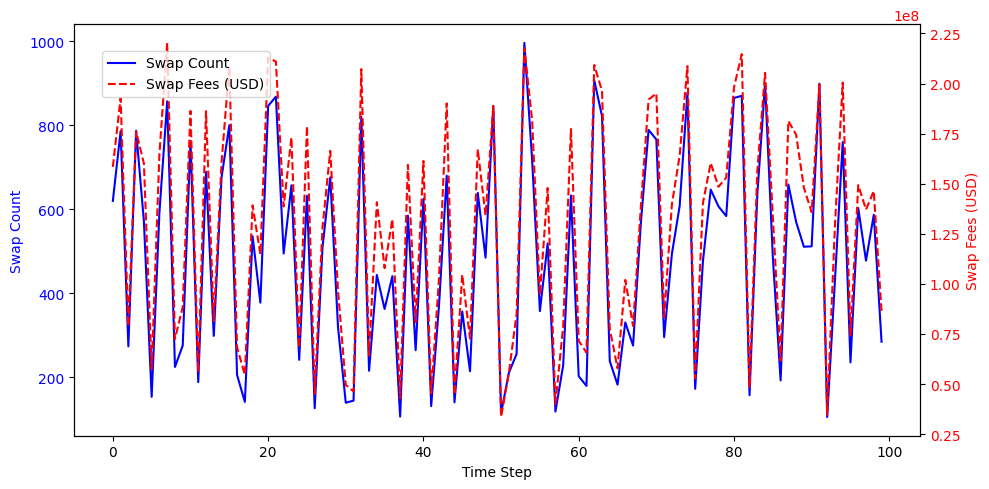

In [21]:
#@title Swaps Count VS Swaps Fees

plt.figure(figsize=(10, 5))
plt.plot(swap_count_history, label='Daily Swap Count', color='blue')
plt.title("Daily Swap Count Over Time")
plt.xlabel("Time Step")
plt.ylabel("Swap Count")
plt.legend()
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(fees_history, label='Daily Swap Fees (in USD)', color='red')
plt.title("Daily Swap Fees Over Time")
plt.xlabel("Time Step")
plt.ylabel("Swap Fees (USD)")
plt.legend()
plt.tight_layout()
plt.show()


fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(swap_count_history, label='Swap Count', color='blue')
ax1.set_xlabel("Time Step")
ax1.set_ylabel("Swap Count", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(fees_history, label='Swap Fees (USD)', color='red', linestyle='--')
ax2.set_ylabel("Swap Fees (USD)", color='red')
ax2.tick_params(axis='y', labelcolor='red')

fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.show()


# Impermanent Loss

Straightforward formula for calculating impermanent loss:

without fees:
$$
\frac{stake_{USD}}{hold_{USD}} - 1
$$

with fees:
$$
\frac{stake_{USD} + \text{fee}}{hold_{USD}} - 1
$$

Example:

example(1)

without fees:
$$
\frac{282.821}{300} - 1 ≈ -0.0572 ≈ \text{-5.72%}
$$

example(2)

with fees:
$$
\frac{282.821 + 30}{300} - 1 ≈ 0.042 ≈ \text{4.2%}
$$



Basic Formula:
$$
IL(k) = 2 \cdot \frac{\sqrt{k}}{1 + k} - 1
$$

where:
$$
k = \frac{r_{t1}}{r_{t2}}
$$

Example:
we stake 1 ETH = 100 USDC, next week 1 ETH = 200 USDC



$$
r_{t1} = 100 \\
r_{t2} = 200 \\
p = \frac{r_{t1}}{r_{t2}} = 0.5
$$

apply formula:
$$
2 \cdot \frac{\sqrt{0.5}}{1 + 0.5} - 1 \approx  -0.0572 ≈ \text{-5.72%}
$$

Same with example(1)

apply with tradings fees:
$$
2 \cdot \frac{\sqrt{k}}{k + 1} + \frac{fees_{USD}}{hold_{USD}}  - 1
$$










In [22]:
class ImpermanentLoss:
  def __init__(self,x, y , price_x, price_y):
    # base asset
    self.x = x
    self.price_x = price_x

    # quote asset
    self.price_y = price_y
    self.y = y

    self.initial_values = self.x * self.price_x + self.y * self.price_y



  def _cal_(self, market_price_x, market_price_y):
    price_ratio = self.price_y / market_price_y

    return ((2 * np.sqrt(price_ratio)) / (1 + price_ratio) - 1) * 100


  def _cal_with_fees(self, market_price_x, market_price_y, fees_usd):
    price_ratio = self.price_y / market_price_y

    il = ((2 * np.sqrt(price_ratio)) / (1 + price_ratio))

    fee = fees_usd / self.initial_values

    total = il + fee

    return (total - 1) * 100

## Scenario 5: Impermanent Loss

In [23]:

tvl_history = []
x_balance_history = []
y_balance_history = []
price_y_history = []
fees_history = []
swap_count_history = []

my_fees_usd = []
daily_il_with_fees = []
daily_il_without_fees = []

# Create pool ETH/USD
ethusd_pool = UniswapV2(price_x=1, price_y=2000)

# Add Liquidity
ethusd_pool.add_liquidity(delta_y=2000)


# my position 10% of pool
stake_x = ethusd_pool.x * 0.1
stake_y = ethusd_pool.y * 0.1

my_position = ImpermanentLoss(x=stake_x, y=stake_y, price_x=1, price_y=2000)


for i in range(100):
  fluctuation = np.random.uniform(0.75, 1.2)
  ethusd_pool.rebalance_pool(market_price=ethusd_pool.price_y * fluctuation)

  daily_swaps = 0
  daily_swaps_fee = 0



  for _ in range(np.random.randint(1,10)):
    if np.random.rand() < 0.5:
      delta_x = np.random.uniform(0.00005,0.01) * ethusd_pool.x
      fee = (ethusd_pool.swap_x_to_y(delta_x)) * 0.003
      swap_fee = fee * ethusd_pool.x # convert to usd
      daily_swaps_fee += swap_fee

    else:
      delta_y = np.random.uniform(0.00005,0.01) * ethusd_pool.y
      swap_fee = (ethusd_pool.swap_y_to_x(delta_y)) * 0.003
      daily_swaps_fee += swap_fee

    daily_swaps += 1

  tvl_history.append(ethusd_pool.calculate_tvl())
  x_balance_history.append(ethusd_pool.x)
  y_balance_history.append(ethusd_pool.y)
  price_y_history.append(ethusd_pool.price_y)
  fees_history.append(daily_swaps_fee)
  swap_count_history.append(daily_swaps)



  my_fees = daily_swaps_fee * 0.1
  my_fees_usd.append(my_fees)
  daily_il_without_fees.append(my_position._cal_(market_price_x=1, market_price_y=ethusd_pool.price_y))
  daily_il_with_fees.append(my_position._cal_with_fees(market_price_x=1, market_price_y=ethusd_pool.price_y,fees_usd=my_fees))


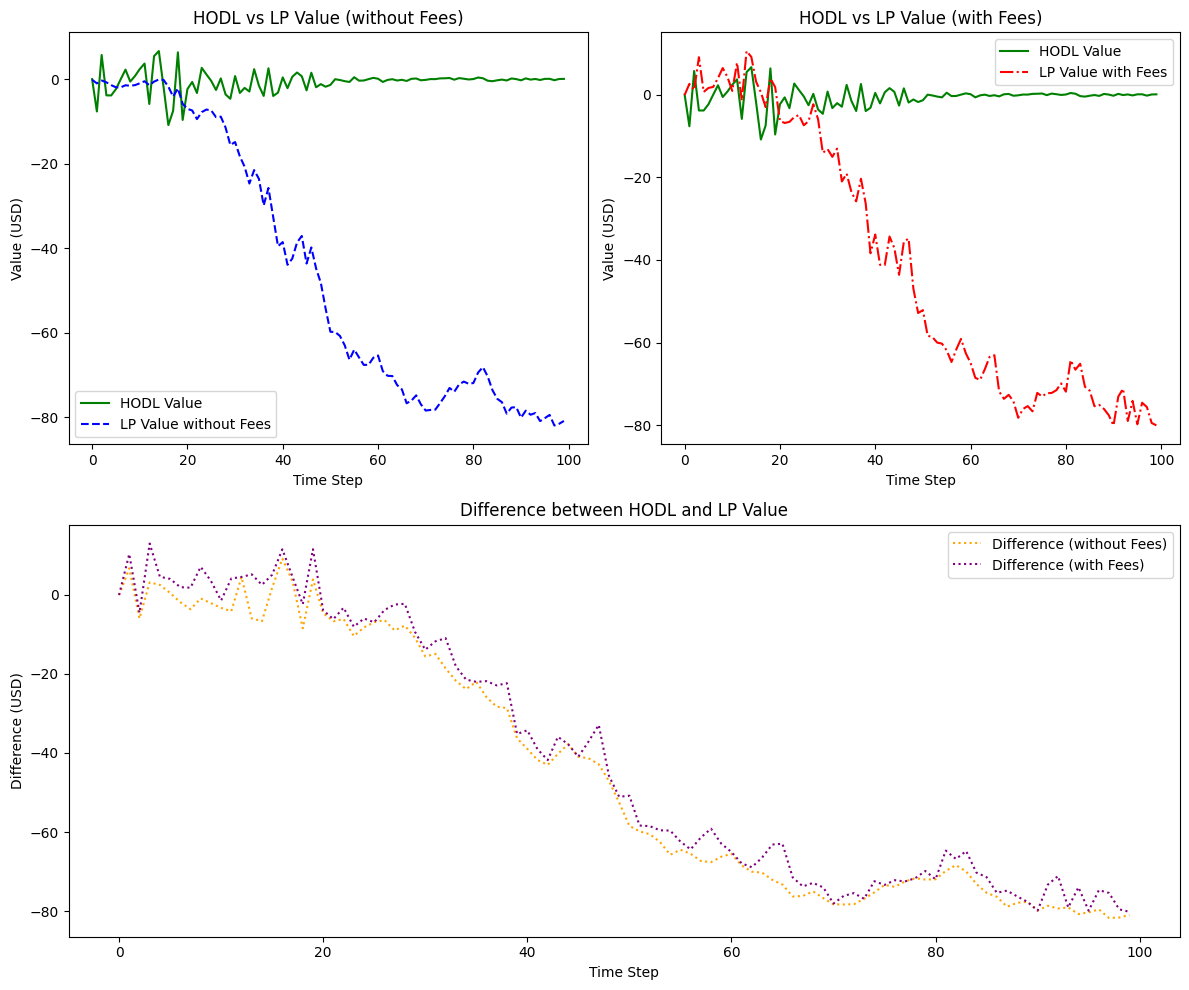

In [24]:
hodl_value = [(stake_x + stake_y * price) for price in price_y_history]

hodl_value_shift = [(hodl_value[i] - hodl_value[i-1]) / hodl_value[i-1] * 100 for i in range(1, len(hodl_value))]
hodl_value_shift = [0] + hodl_value_shift

diff_hodl_vs_lp = np.array(daily_il_without_fees) - np.array(hodl_value_shift)
diff_hodl_vs_lp_with_fees = np.array(daily_il_with_fees) - np.array(hodl_value_shift)


fig, axs = plt.subplots(2, 2, figsize=(12, 10))


axs[1, 0].remove()
axs[1, 1].remove()

gs = axs[1,0].get_gridspec()
ax_big = fig.add_subplot(gs[1,:])


# Plot 1: HODL vs LP Value without Fees
axs[0, 0].plot(hodl_value_shift, label="HODL Value", color="green")
axs[0, 0].plot(daily_il_without_fees, label="LP Value without Fees", color="blue", linestyle="--")
axs[0, 0].set_title("HODL vs LP Value (without Fees)")
axs[0, 0].set_xlabel("Time Step")
axs[0, 0].set_ylabel("Value (USD)")
axs[0, 0].legend()

# Plot 2: HODL vs LP Value with Fees
axs[0, 1].plot(hodl_value_shift, label="HODL Value", color="green")
axs[0, 1].plot(daily_il_with_fees, label="LP Value with Fees", color="red", linestyle="-.")
axs[0, 1].set_title("HODL vs LP Value (with Fees)")
axs[0, 1].set_xlabel("Time Step")
axs[0, 1].set_ylabel("Value (USD)")
axs[0, 1].legend()

# Plot 3: Difference: HODL vs LP (without Fees)
ax_big.plot(diff_hodl_vs_lp, label="Difference (without Fees)", color="orange", linestyle=":")
ax_big.plot(diff_hodl_vs_lp_with_fees, label="Difference (with Fees)", color="purple", linestyle=":")
ax_big.set_title("Difference between HODL and LP Value")
ax_big.set_xlabel("Time Step")
ax_big.set_ylabel("Difference (USD)")
ax_big.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()